In [2]:
import math
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.validation import make_valid
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import geopandas as gpd
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import utm #pip install utm
from pyproj import CRS
from shapely.geometry import Polygon, Point, LineString
from math import atan2, degrees

In [3]:
tracts = gpd.read_file('sf-tracts-2020-clipped.geojson')
tracts_016801 = tracts[tracts['TRACTCE20']=='016801']
tracts_016801

,TRACTCE20,geometry
84,016801,"MULTIPOLYGON (((-122.43082 37.77397, -122.4324..."


In [29]:
# Function to convert Footprint2D string to list of points
def footprint_to_polygon(footprint_str):
    points = [tuple(list(map(float, point.split(',')))[::-1]) for point in footprint_str.split()]
    return Polygon(points)
def convert_footprint_to_points(footprint):
    points = footprint.split('_')
    point_tuples = [tuple(map(float, point.split('/'))) for point in points]
    return point_tuples
def convert_polygon_to_tuples(polygon):
    # Extract the exterior coordinates of the polygon
    coords = list(polygon.exterior.coords)
    return coords

In [127]:
raw = pd.read_csv('SF.csv')
data4shading = raw[['ID','Footprint2D', 'Height', 'WWR_surfaces','lat','lon']]
data4shading['FootprintPoints'] = data4shading['Footprint2D'].apply(convert_footprint_to_points)
data4shading['FootprintPointsStr'] = data4shading['FootprintPoints'].apply(lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x]))
data4shading['geometry'] = data4shading['FootprintPointsStr'].apply(footprint_to_polygon)
gdf = gpd.GeoDataFrame(data4shading, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
utm_crs = gdf.estimate_utm_crs()
print(utm_crs)
gdf = gdf.to_crs(utm_crs)
gdf['geometry_points'] = gdf.geometry.centroid

# Extract lat and lon from the UTM CRS
gdf['lat_utm'] = gdf.geometry_points.y
gdf['lon_utm'] = gdf.geometry_points.x
gdf['coordinates'] = gdf['geometry'].apply(convert_polygon_to_tuples)
gdf.head(2)

C:\Users\vapeu\AppData\Local\Temp\ipykernel_12812\3177758091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4shading['FootprintPoints'] = data4shading['Footprint2D'].apply(convert_footprint_to_points)
C:\Users\vapeu\AppData\Local\Temp\ipykernel_12812\3177758091.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4shading['FootprintPointsStr'] = data4shading['FootprintPoints'].apply(lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x]))
C:\Users\vapeu\AppData\Local\Temp\ipykernel_12812\3177758091

EPSG:32610


,ID,Footprint2D,Height,WWR_surfaces,lat,lon,FootprintPoints,FootprintPointsStr,geometry,geometry_points,lat_utm,lon_utm,coordinates
0,90032007980815,37.799329/-122.447322_37.799362/-122.447029_37...,61.992934,.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15,37.799148,-122.447165,"[(37.799329, -122.447322), (37.799362, -122.44...","37.799329,-122.447322 37.799362,-122.447029 37...","POLYGON ((548655.767 4183694.366, 548681.540 4...",POINT (548669.716 4183674.384),4.183674e+06,548669.715686,"[(548655.7668084321, 4183694.3661477994), (548..."
1,90032007980816,37.79428/-122.437969_37.794291/-122.437867_37....,111.365812,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...,37.794191,-122.437547,"[(37.79428, -122.437969), (37.794291, -122.437...","37.79428,-122.437969 37.794291,-122.437867 37....","POLYGON ((549482.545 4183139.091, 549491.518 4...",POINT (549519.793 4183129.454),4.183129e+06,549519.792754,"[(549482.5453899564, 4183139.0911058243), (549..."


In [133]:
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.to_crs(epsg=4326, inplace=True)

gdf_clean = gdf[['ID','Height','WWR_surfaces','lat','lon','geometry','FootprintPointsStr','coordinates']]
gdf_clean.head(2)

,ID,Height,WWR_surfaces,lat,lon,geometry,FootprintPointsStr,coordinates
0,90032007980815,61.992934,.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15,37.799148,-122.447165,"POLYGON ((-122.44732 37.79933, -122.44703 37.7...","37.799329,-122.447322 37.799362,-122.447029 37...","[(548655.7668084321, 4183694.3661477994), (548..."
1,90032007980816,111.365812,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...,37.794191,-122.437547,"POLYGON ((-122.43797 37.79428, -122.43787 37.7...","37.79428,-122.437969 37.794291,-122.437867 37....","[(549482.5453899564, 4183139.0911058243), (549..."


In [134]:
gdf_clean.shape

(37668, 8)

In [135]:
gdf_clean = gdf_clean.set_crs(tracts_016801.crs)
gdf_clean = gdf_clean.to_crs(tracts_016801.crs)

# Filter gdf_clean based on whether the centroid falls within the geometries in tracts_016801
minx, miny, maxx, maxy = tracts_016801.total_bounds
filtered_gdf = gdf_clean.cx[minx:maxx, miny:maxy]
filtered_gdf.shape

(105, 8)

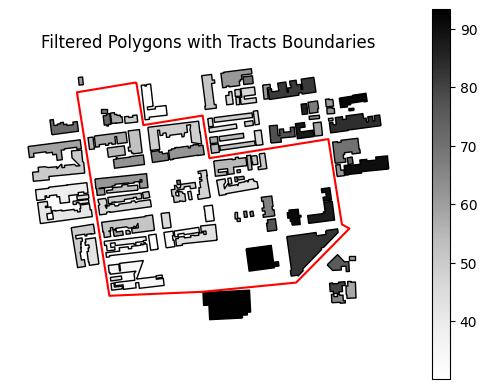

In [136]:

# Set the geometry back to the original polygons for filtered_gdf
filtered_gdf = filtered_gdf.set_geometry('geometry')

# Create a plot with a transparent background
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)  # Make the background of the figure transparent
ax.set_facecolor('none')  # Make the background of the plot area transparent

# Plot the filtered polygons with the specified color map and edge color
filtered_gdf.plot(column='Height', cmap='Grays', legend=True, edgecolor='black', ax=ax)

# Plot the tracts_016801 boundaries on the same axis
tracts_016801.boundary.plot(ax=ax, color='red', linewidth=1.5)  # Adjust color and linewidth as needed

# Add title and labels
plt.title('Filtered Polygons with Tracts Boundaries', backgroundcolor='none')  # No background color for the title
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Remove the axis background
ax.set_facecolor('none')
ax.axis('off')

# Save the plot with a transparent background
plt.savefig('tract_building.png', transparent=True)

# Show the plot
plt.show()

In [137]:
filtered_gdf.to_csv('buildings.csv')

In [138]:
filtered_gdf

,ID,Height,WWR_surfaces,lat,lon,geometry,FootprintPointsStr,coordinates
38,90032007980857,49.694616,.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.1...,37.770501,-122.432358,"POLYGON ((-122.43263 37.77080, -122.43201 37.7...","37.770795,-122.432626 37.770873,-122.432012 37...","[(549968.7685120854, 4180536.2872691816), (550..."
42,90032007980860,52.042563,.27_.27_.27_.27_.27_.27_.27_.27_.27_.27_.27_.27,37.773769,-122.428826,"POLYGON ((-122.42874 37.77395, -122.42867 37.7...","37.77395,-122.428743 37.773487,-122.428668 37....","[(550308.610310629, 4180888.4132863553), (5503..."
60,90032007980882,40.703145,.33_.33_.33_.33_.33_.33_.33_.33,37.771360,-122.432349,"POLYGON ((-122.43258 37.77137, -122.43215 37.7...","37.771373,-122.432579 37.771414,-122.432146 37...","[(549972.5188378964, 4180600.440971836), (5500..."
149,90032007980981,45.989290,.27_.27_.27_.27_.27_.27_.27_.27_.27_.27_.27_.2...,37.771264,-122.431228,"POLYGON ((-122.43044 37.77141, -122.43041 37.7...","37.771408,-122.430436 37.771256,-122.430409 37...","[(550161.2298291139, 4180605.4712430076), (550..."
152,90032007980985,34.627846,.006_.006_.006_.006_.006_.006_.006_.006_.006_....,37.769741,-122.430858,"POLYGON ((-122.43082 37.76967, -122.43027 37.7...","37.769673,-122.430816 37.769724,-122.430271 37...","[(550128.9344494082, 4180412.77080155), (55017..."
...,...,...,...,...,...,...,...,...
24769,90033008213201,65.060454,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...,37.769235,-122.425248,"POLYGON ((-122.42541 37.76915, -122.42543 37.7...","37.769155,-122.425414 37.769335,-122.425426 37...","[(550605.0541499837, 4180358.2078114273), (550..."
25471,90033008213954,80.179462,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...,37.769490,-122.425275,"POLYGON ((-122.42548 37.76958, -122.42539 37.7...","37.769582,-122.425478 37.769587,-122.425392 37...","[(550599.126513149, 4180405.5484679798), (5506..."
25872,90033008214368,58.375019,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33,37.769428,-122.424881,"POLYGON ((-122.42502 37.76932, -122.42502 37.7...","37.769324,-122.425015 37.76952,-122.425024 37....","[(550640.0800028691, 4180377.174140644), (5506..."
27292,90033008215839,59.099183,.15_.15_.15_.15,37.770136,-122.424865,"POLYGON ((-122.42478 37.77009, -122.42495 37.7...","37.770088,-122.42478 37.770088,-122.424951 37....","[(550660.255853901, 4180462.0665267203), (5506..."


In [139]:
filtered_gdf['FootprintPointsStr'] = filtered_gdf['coordinates'].apply(lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x]))
filtered_gdf[['ID','Height', 'coordinates']].to_csv(f'GH_building.csv', index=False)

In [145]:
from shapely import wkt

In [146]:
tree = pd.read_csv('tract_016801_tree_canopy.csv')
tree['geometry'] = tree['geometry'].apply(wkt.loads)
tree

,Unnamed: 0,geometry,height
0,234427,MULTIPOLYGON (((-122.43039714417392 37.7694125...,11
1,234455,MULTIPOLYGON (((-122.43081696703868 37.7694497...,11
2,234482,MULTIPOLYGON (((-122.4303283280147 37.76949450...,11
3,234483,MULTIPOLYGON (((-122.4300645665975 37.76950386...,11
4,234484,MULTIPOLYGON (((-122.43017113896505 37.7695013...,11
...,...,...,...
517,238392,MULTIPOLYGON (((-122.43156749998897 37.7738427...,18
518,238420,MULTIPOLYGON (((-122.43116909664582 37.7738768...,15
519,238425,MULTIPOLYGON (((-122.43129149786651 37.7738754...,18
520,238469,MULTIPOLYGON (((-122.4309468511749 37.77392990...,15


In [153]:
def convert_polygon_to_tuples(geometry):
    # Check if the geometry is a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        # Extract coordinates for each Polygon in the MultiPolygon
        all_coords = []
        for polygon in geometry.geoms:
            coords = list(polygon.exterior.coords)
            all_coords.append(coords)
        return all_coords
    elif geometry.geom_type == 'Polygon':
        # If it's a single Polygon, extract the exterior coordinates
        return list(geometry.exterior.coords)
    else:
        raise TypeError("Input must be a Polygon or MultiPolygon")

# Example usage
# Assuming 'geometry' is a column in your GeoDataFrame with Polygon/MultiPolygon geometries:
gdf['coordinates'] = gdf['geometry'].apply(convert_polygon_to_tuples)

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [173]:
tree = gpd.GeoDataFrame(tree, geometry='geometry')
utm_crs = tree.estimate_utm_crs()
print(utm_crs)
tree = tree.to_crs(utm_crs)
def flatten_list(coords):
    return coords[0]  # Access the first element of the outer list

# Apply the function to the entire 'coordinates' column
tree['coordinates'] = tree['coordinates'].apply(flatten_list)

tree = tree.rename(columns={'height': 'Height'})
tree.head(2)

EPSG:32610


,Unnamed: 0,geometry,Height,coordinates,FootprintPointsStr,coordinates2
0,234427,"MULTIPOLYGON (((550166.000 4180384.100, 550166...",11,"[(550165.9999996825, 4180384.1001009746), (550...","(550165.9999996825, 4180384.1001009746),(55016...",NaN
1,234455,"MULTIPOLYGON (((550129.000 4180388.000, 550129...",11,"[(550128.9999996853, 4180388.000110493), (5501...","(550128.9999996853, 4180388.000110493),(550128...","[[(550128.9999996853, 4180388.000110493), (550..."


In [174]:
tree['FootprintPointsStr'] = tree['coordinates'].apply(lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x]))
tree[['Height', 'coordinates']].to_csv(f'GH_tree.csv', index=False)

In [1]:
tree.plot()

NameError: name 'tree' is not defined